# Personality Detection from Face Videos using Deep id
Notebook ini berisi implementasi model untuk memprediksi trait kepribadian OCEAN (Openness, Conscientiousness, Extraversion, Agreeableness, Neuroticism) dari video wajah menggunakan Deepid dan LSTM.

## 1. Setup Awal

In [2]:
# Import library yang diperlukan
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import datetime
import os
from pathlib import Path
from sklearn.metrics import mean_absolute_error

# Konfigurasi untuk reproduktibilitas
tf.random.set_seed(42)
np.random.seed(42)

# Cek ketersediaan GPU
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: []


## 2. Memuat Dataset

In [6]:
train_ds = tf.data.Dataset.load('data/videoface/train_ds') \
    .cache().shuffle(buffer_size=1000, seed=42).prefetch(buffer_size=tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.load('data/videoface/val_ds') \
    .cache().shuffle(buffer_size=1000, seed=42).prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds, valid_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 10, 55, 47, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 10, 55, 47, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>)

## 3. Membangun Model Deep ID + LSTM

In [2]:
from models import model_deepid

deepid = model_deepid()
deepid.trainable = False
deepid.summary()

from tensorflow.keras.utils import plot_model
plot_model(deepid, to_file='deepid_architecture.png', show_shapes=True, show_layer_names=True)

from IPython.display import Image
Image(filename='deepid_architecture.png')

for i, layer in enumerate(deepid.layers):
    print(f"{i+1}. {layer.name}")
    print(f"   Input shape: {layer.input_shape}")
    print(f"   Output shape: {layer.output_shape}")


Model: "DeepID"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 52, 44, 20)   980         ['input_1[0][0]']                
                                                                                                  
 pool1 (MaxPooling2D)           (None, 26, 22, 20)   0           ['conv1[0][0]']                  
                                                                                                  
 dropout1 (Dropout)             (None, 26, 22, 20)   0           ['pool1[0][0]']                  
                                                                                             

## 4. Build Model

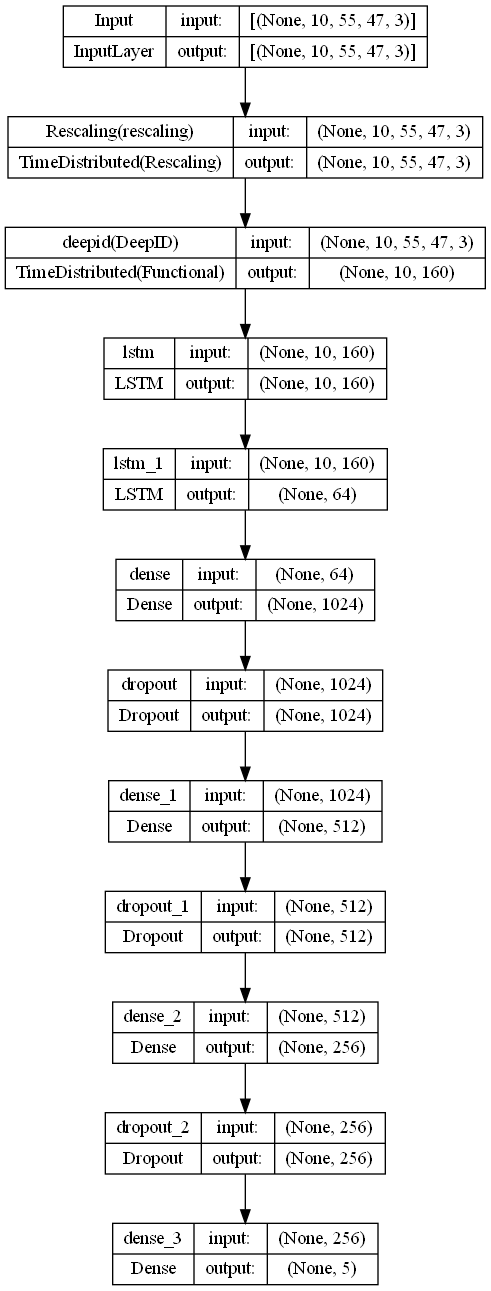

In [3]:
from tensorflow.keras import regularizers

inputs = keras.layers.Input(shape=(10,55,47,3), name='Input')

# Preprocessing
x = keras.layers.TimeDistributed(keras.layers.Rescaling(scale=1./255.0), name='Rescaling')(inputs)

# OpenFace feature extractor (tetap dibekukan)
deepid.trainable = False
x = keras.layers.TimeDistributed(deepid, name='deepid')(x)

# LSTM layers
x = keras.layers.LSTM(units=160, return_sequences=True)(x)
x = keras.layers.LSTM(units=64)(x)

# Dense + Dropout + Regularization
x = keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = keras.layers.Dropout(0.3)(x)

x = keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = keras.layers.Dropout(0.3)(x)

x = keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = keras.layers.Dropout(0.5)(x)

# Output
x = keras.layers.Dense(5, activation='sigmoid')(x)

# Build model
model = keras.models.Model(inputs=inputs, outputs=x)
keras.utils.plot_model(model, show_shapes=True)

## 5. Compile Model

In [ ]:
t = datetime.datetime.now().strftime("%m%d_%H%M%S")

optimizer = keras.optimizers.Adam()
#optimizer = keras.optimizers.SGD()
#optimizer = keras.optimizers.RMSprop()

def acc(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    accuracy = (1-mae)*100
    
    return accuracy

def loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred)) * 100

early_stopping = keras.callbacks.EarlyStopping(patience=10, verbose=0)
check_point    = keras.callbacks.ModelCheckpoint(filepath='./weights/face/'+str(t)+'/face.t5',
                            monitor='val_acc',
                            mode='max',
                            save_best_only=True,
                            save_weights_only=True,
                            verbose=0)

model.compile(loss=loss,optimizer=optimizer, metrics=[acc]) #optimizer=optimizer

## 6. Training

In [30]:
history = model.fit(train_ds, validation_data=valid_ds, batch_size=8, epochs=100, callbacks=[early_stopping, check_point])
# 0613_104743 - 15.2s 5 data

Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 7.9983 - acc: 99.9999 - val_loss: 6.8555 - val_acc: 100.0000
Epoch 2/100
1/1 [==============================] - 0s 88ms/step - loss: 6.8555 - acc: 100.0000 - val_loss: 6.1315 - val_acc: 100.0000
Epoch 3/100
1/1 [==============================] - 0s 86ms/step - loss: 6.1315 - acc: 100.0000 - val_loss: 5.5839 - val_acc: 100.0000
Epoch 4/100
1/1 [==============================] - 0s 106ms/step - loss: 5.5846 - acc: 99.9992 - val_loss: 5.1369 - val_acc: 100.0000
Epoch 5/100
1/1 [==============================] - 0s 94ms/step - loss: 5.1379 - acc: 99.9990 - val_loss: 4.7559 - val_acc: 100.0000
Epoch 6/100
1/1 [==============================] - 0s 110ms/step - loss: 4.7559 - acc: 100.0000 - val_loss: 4.4209 - val_acc: 100.0000
Epoch 7/100
1/1 [==============================] - 0s 96ms/step - loss: 4.4211 - acc: 99.9998 - val_loss: 4.1229 - val_acc: 100.0000
Epoch 8/100
1/1 [==============================] - 0s 97ms/step - 

## 7. Evaluation

In [3]:
model.load_weights('./weights/face/0613_124447/face.t5')

NameError: name 'model' is not defined

In [23]:
def acc_per_trait_and_mean(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
    acc_per_trait = (1 - mae) * 100
    mean_acc = (1 - np.mean(mae)) * 100
    return acc_per_trait, mean_acc

Training data

In [24]:
train_ds = tf.data.Dataset.load('data/videoface/train_ds') 
loss, mae = model.evaluate(train_ds)
acc

1/1 [==============================] - 0s 57ms/step - loss: 7.9982 - acc: 100.0000


<function __main__.acc(y_true, y_pred)>

In [25]:
y_true = np.concatenate([y for x,y in train_ds])
y_pred = model.predict(train_ds)

acc_per_trait, mean_acc = acc_per_trait_and_mean(y_true, y_pred)

acc_per_trait, mean_acc


1/1 [==============================] - 1s 913ms/step


(array([ 99.999985, 100.      ,  99.99999 , 100.      , 100.      ],
       dtype=float32),
 99.99999501668633)

Validation data

In [26]:
valid_ds = tf.data.Dataset.load('data/videoface/val_ds') 
loss, mae = model.evaluate(valid_ds)
acc

1/1 [==============================] - 0s 42ms/step - loss: 7.9981 - acc: 100.0000


<function __main__.acc(y_true, y_pred)>

In [27]:
y_true = np.concatenate([y for x,y in valid_ds])
y_pred = model.predict(valid_ds)

mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
(1-mae)*100, (1-np.mean(mae))*100

1/1 [==============================] - 0s 43ms/step


(array([ 99.99999, 100.     , 100.     , 100.     , 100.     ],
       dtype=float32),
 99.99999855733677)

Test data

In [28]:
test_ds = tf.data.Dataset.load('data/videoface/test_ds')
loss, mae = model.evaluate(test_ds)
acc

1/1 [==============================] - 0s 39ms/step - loss: 7.9982 - acc: 100.0000


<function __main__.acc(y_true, y_pred)>

In [18]:
y_true = np.concatenate([y for x,y in test_ds])
y_pred = model.predict(test_ds)

acc_per_trait, mean_acc = acc_per_trait_and_mean(y_true, y_pred)

acc_per_trait, mean_acc

1/1 [==============================] - 0s 46ms/step


(array([ 99.99996, 100.     ,  99.99999,  99.99999,  99.99999],
       dtype=float32),
 99.99998928422542)

## 8. History Graph

In [ ]:
import os
import pickle

t = '0613_124447'

os.makedirs(f'./histories/{t}', exist_ok=True)

with open(f'./histories/{t}/face_histories.pkl', 'wb') as f:
    pickle.dump(history.history, f)


NameError: name 'history' is not defined

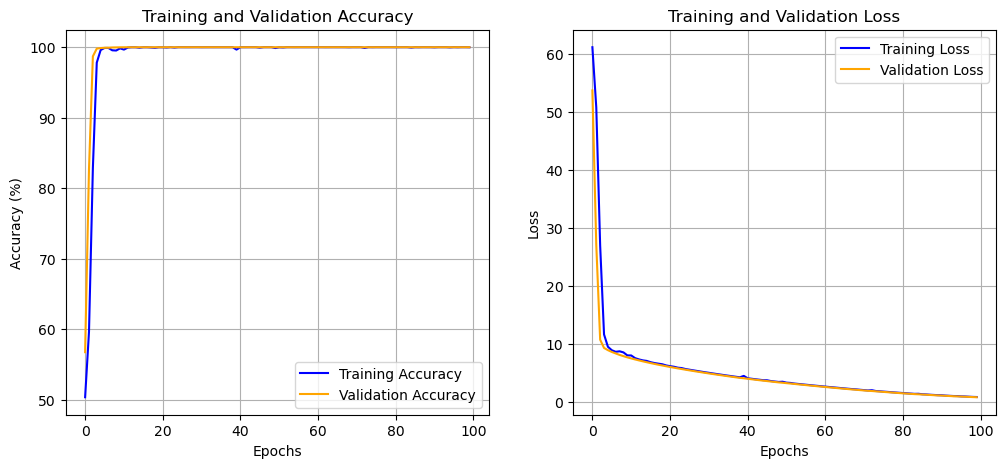

Final Training Loss: 0.8295 | Final Validation Loss: 0.7930
Final Training Accuracy: 99.99% | Final Validation Accuracy: 100.00%


In [16]:
from utils import loss_val_graph

# Tampilkan grafik training vs validation
loss_val_graph(history)


## README
#### Notebook ini digunakan untuk memprediksi kepribadian berdasarkan citra wajah menggunakan pendekatan transfer learning model deep id. Model dilatih untuk menghasilkan skor kepribadian berdasarkan lima dimensi OCEAN (Openness, Conscientiousness, Extraversion, Agreeableness, Neuroticism).

#### Hal yang perlu diperhatikan:
1. Persiapkan data preparation yang diperlukan
2. Instalasi library
3. Sesuaikan Path dataset
4. Pada tahap 7 (evaluation), rubah weights sesuai folder yang telah terbuat saat menjalankan training
5. Pada tahap 8 (history graph), rubah timestamp sesuai pada folder weights sebelumnya